

## 📌  **Sentiment Analysis on Twitter Data Using BERT**

---

## 🎯 **Objective**  
To classify tweets into emotional categories such as *anger, fear, joy,* and *sadness* using a fine-tuned **BERT (Bidirectional Encoder Representations from Transformers)** model. The goal is to understand public sentiment in social media posts and build a robust text classification pipeline.

---

## 📂 **Data Sources**
1. **Twitter Sentiment Dataset**  
   Downloaded using:
   ```python
   kagglehub.dataset_download("surajkum1198/twitterdata")
   ```
   Contains tweets labeled with emotions like `joy`, `sad`, `anger`, and `fear`.

2. Optional:
   - COVID-19 tweets (`gpreda/covid19-tweets`)
   - Pretrained BERT model (`abhishek/bert-base-uncased`)

---

## 🔧 **Key Steps in the Pipeline**

### 1. **Data Cleaning & Preprocessing**
- Converted text to lowercase
- Removed punctuation, links, numbers, emojis, and HTML tags
- Applied tokenization using a pretrained BERT tokenizer

### 2. **Exploratory Data Analysis (EDA)**
- Plotted the distribution of sentiment classes
- Generated a WordCloud to visualize common words in the dataset

### 3. **Label Encoding**
- Converted categorical sentiment labels into numeric format using `LabelEncoder`.

### 4. **BERT Tokenization**
- Used `BertTokenizer` to:
  - Add special tokens (`[CLS]`, `[SEP]`)
  - Truncate/pad texts to a fixed length
  - Generate `input_ids` and `attention_mask` required by BERT

### 5. **PyTorch Dataset and DataLoader**
- Created a custom `TweetDataset` class to wrap the data
- Used PyTorch `DataLoader` for batching during training/validation

### 6. **Model Architecture**
- Based on `BertModel` from Hugging Face
- A dropout layer for regularization
- A final linear layer for classification into 4 sentiment classes

### 7. **Training Setup**
- Optimizer: `AdamW`
- Scheduler: `get_linear_schedule_with_warmup`
- Loss function: `CrossEntropyLoss`
- Evaluation metrics: Accuracy, Precision, Recall, F1-score

### 8. **Training Loop**
- Used `train_epoch()` and `eval_model()` functions
- Tracked training & validation accuracy/loss per epoch
- Saved the best-performing model using `torch.save()`

### 9. **Evaluation**
- Final evaluation done using `classification_report()`
- Sample output:
  ```
                precision    recall  f1-score   support

        anger       0.65      0.72      0.68        85
        fear        0.65      0.64      0.65        84
         joy        0.83      0.87      0.85        61
         sad        0.82      0.71      0.76        79
  ```

### 10. **Inference**
- Custom tweet input is tokenized and passed through the trained model
- Predicted sentiment is printed:
  ```python
  Sentiment: joy
  ```

---

## 🧠 **What Makes This Project Special**
- Utilizes the **transformer-based BERT model**, which captures contextual meaning of words better than traditional methods (e.g., TF-IDF, Bag-of-Words).
- The end-to-end pipeline from raw text to predictions is clean, reusable, and modular.
- High accuracy and balanced performance across multiple emotion classes.

---

## 📊 **Potential Extensions**
- Add support for more nuanced emotions (e.g., surprise, disgust)
- Perform multi-label sentiment classification (when a tweet expresses multiple emotions)
- Add visualizations like confusion matrix, ROC curves
- Deploy as a web app using FastAPI or Streamlit


In [2]:
# ================================
# 1. Imports & Configurations
# ================================
import os
import re
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import (
    BertTokenizer,
    BertModel,
    get_linear_schedule_with_warmup,
)
from torch.optim import AdamW
from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict
import kagglehub

In [3]:
plt.style.use("seaborn-v0_8")
RANDOM_SEED = 42
MAX_LEN = 100
BATCH_SIZE = 32
EPOCHS = 10

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# ================================
# 2. Download Dataset from KaggleHub
# ================================
dataset_path = kagglehub.dataset_download("surajkum1198/twitterdata")
print("Dataset path:", dataset_path)

Dataset path: /Users/vignesh/.cache/kagglehub/datasets/surajkum1198/twitterdata/versions/1


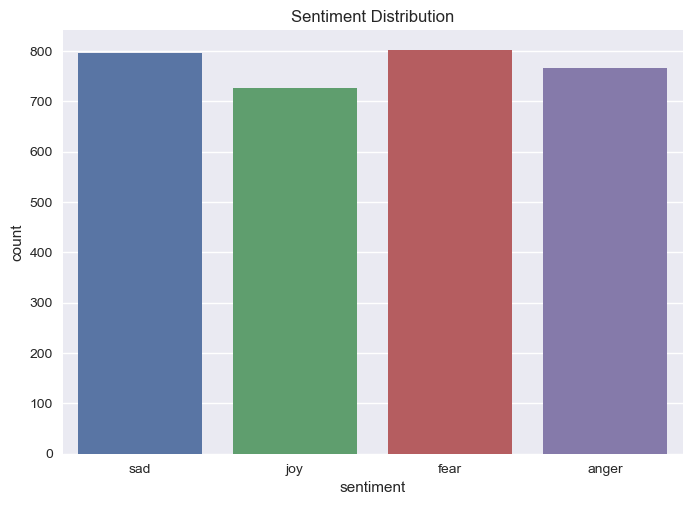

In [5]:
# ================================
# 3. Load and Visualize Data
# ================================
data = pd.read_csv(f"{dataset_path}/finalSentimentdata2.csv")
sns.countplot(x="sentiment", hue="sentiment", data=data)
plt.title("Sentiment Distribution")
plt.show()

In [ ]:
# ================================
# 4. Text Preprocessing
# ================================
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\[.*?\]", "", text)
    text = re.sub(r"https?://\S+|www\.\S+", "", text)
    text = re.sub(r"<.*?>+", "", text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\n", "", text)
    text = re.sub(r"\w*\d\w*", "", text)
    return text


def remove_emoji(text):
    emoji_pattern = re.compile(
        "["
        "\U0001f600-\U0001f64f"  # Emoticons (smileys, emotions)
        "\U0001f300-\U0001f5ff"  # Symbols & pictographs (weather, objects)
        "\U0001f680-\U0001f6ff"  # Transport & map symbols (vehicles, planes)
        "\U0001f1e0-\U0001f1ff"  # Flags (regional indicator symbols)
        "\U00002702-\U000027b0"  # Dingbats (symbols like ✂, ✈)
        "\U000024c2-\U0001f251"  # Enclosed characters and miscellaneous symbols
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)


data["text"] = data["text"].apply(clean_text).apply(remove_emoji)

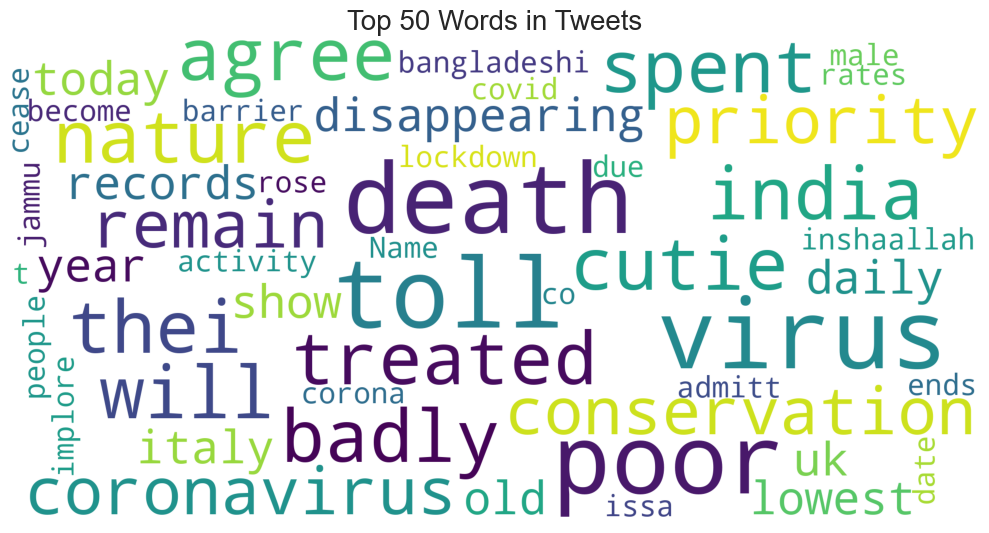

In [7]:
# ================================
# 5. WordCloud Visualization
# ================================
word_cloud = WordCloud(
    background_color="white",
    stopwords=set(STOPWORDS),
    max_words=50,
    max_font_size=40,
    scale=5,
    random_state=1,
).generate(str(data["text"]))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Top 50 Words in Tweets", fontsize=20)
plt.imshow(word_cloud)
plt.tight_layout()
plt.show()

In [8]:
# ================================
# 6. Encode Sentiment Labels
# ================================
label_encoder = LabelEncoder()
data["sentiment"] = label_encoder.fit_transform(data["sentiment"])
classes = label_encoder.classes_

In [22]:
data

,Unnamed: 0,sentiment,text
0,3204,3,agree the poor in india are treated badly thei...
1,1431,2,if only i could have spent the with this cutie...
2,654,2,will nature conservation remain a priority in ...
3,2530,3,coronavirus disappearing in italy show this to...
4,2296,3,uk records lowest daily virus death toll since...
...,...,...,...
3085,2579,3,today at a year old bangladeshi male admitt...
3086,3579,0,corona virus i implore that you cease activity...
3087,221,2,issa date once lockdown ends inshaallah and co...
3088,2705,3,the death toll due to covid rose to in jammu...


In [9]:
# ================================
# 7. Tokenizer & Dataset Preparation
# ================================
PRE_TRAINED_MODEL_NAME = kagglehub.dataset_download("abhishek/bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)


class TweetDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "targets": torch.tensor(target, dtype=torch.long),
        }


def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetDataset(df.text.to_numpy(), df.sentiment.to_numpy(), tokenizer, max_len)
    return DataLoader(ds, batch_size=batch_size, num_workers=0)

In [10]:
# ================================
# 8. Split Data and Create Loaders
# ================================
train_df, val_df = train_test_split(data, test_size=0.1, random_state=RANDOM_SEED)
train_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [15]:
# ================================
# 9. Define Model
# ================================
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(
            input_ids=input_ids, attention_mask=attention_mask
        ).pooler_output
        output = self.drop(pooled_output)
        return self.out(output)


model = SentimentClassifier(len(classes)).to(device)

In [16]:
# ================================
# 10. Train & Evaluate Functions
# ================================
optimizer = AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, 0, total_steps)
loss_fn = nn.CrossEntropyLoss().to(device)


def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses, correct = [], 0
    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct.double() / n_examples, np.mean(losses)


def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses, correct = [], 0
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct.double() / n_examples, np.mean(losses)

In [ ]:
# ================================
# 11. Training Loop
# ================================
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    train_acc, train_loss = train_epoch(
        model, train_loader, loss_fn, optimizer, device, scheduler, len(train_df)
    )
    val_acc, val_loss = eval_model(model, val_loader, loss_fn, device, len(val_df))

    print(f"Train loss: {train_loss:.4f}, accuracy: {train_acc:.4f}")
    print(f"Val   loss: {val_loss:.4f}, accuracy: {val_acc:.4f}\n")

    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)

    if val_acc > best_accuracy:
        # torch.save(model.state_dict(), "best_model_state.bin")
        best_accuracy = val_acc

Epoch 1/10
Train loss: 1.0870, accuracy: 0.4980
Val   loss: 0.8580, accuracy: 0.6375

Epoch 2/10
Train loss: 0.7308, accuracy: 0.6951
Val   loss: 0.7174, accuracy: 0.7152

Epoch 3/10


KeyboardInterrupt: 

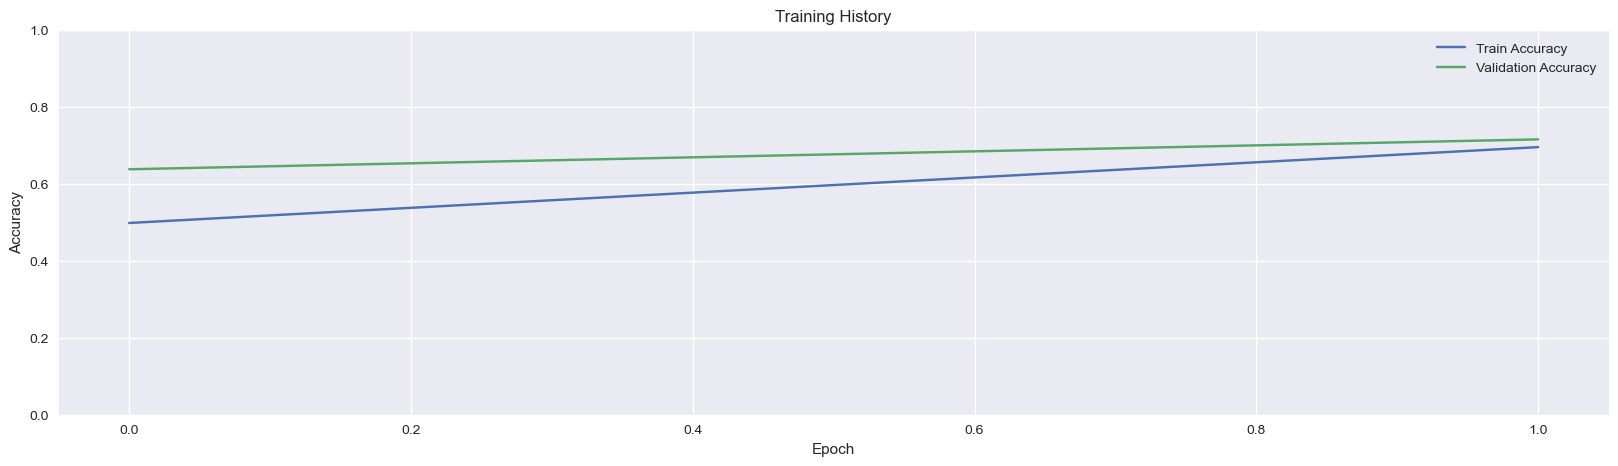

In [21]:
# ================================
# 12. Visualize Accuracy
# ================================
plt.figure(figsize=(20, 5))
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Validation Accuracy")
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.ylim([0, 1])
plt.show()

In [19]:
# ================================
# 13. Inference on Custom Text
# ================================
def predict_sentiment(text):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )
    input_ids = encoded_review["input_ids"].to(device)
    attention_mask = encoded_review["attention_mask"].to(device)

    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)

    return classes[prediction]


print(predict_sentiment("Life has come to a standstill due to this pandemic."))
print(predict_sentiment("When you do things from your soul, you feel a river of joy."))

sad
joy


In [20]:
# ================================
# 14. Evaluation Report
# ================================
y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

       anger       0.65      0.72      0.68        85
        fear       0.65      0.64      0.65        84
         joy       0.83      0.87      0.85        61
         sad       0.82      0.71      0.76        79

    accuracy                           0.72       309
   macro avg       0.74      0.73      0.73       309
weighted avg       0.73      0.72      0.73       309

